In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

In [2]:
def generate_plot(src_path='x_test_sample.csv', img_path='sample1.png'):
    data = pd.read_csv(src_path)
    display(data.head())
    plt.figure(figsize=(16,4), dpi=200)
    sns.lineplot(x=np.linspace(0,data.shape[1],data.shape[1]), y=data.iloc[0,:])
    plt.ylim([0,1])
    plt.savefig(img_path, dpi=200)
    plt.show()
    return

# Goal
Build a neural network that can accurately estimate parameters of a sine function, even when noise is added. Data can then be used to pretrain a network working with sinusoidal type data.

# Variations in Synthetic Data
- **Sine Wave**:  
    - `period` : period of each sign wave, target variable  
    - `amplitude` : amplitude associated with the sine wave  
    - `phase` : where the sine wave starts horizontally
    - `offset` : y location of the sine wave
- **Noise**:
    - `noise distribution` : generating distribution for the noise added to the wave
    - `noise magnitude` : magnitude of noise added to the sine wave
    - `noise method` : multiplicative or additive noise
- **Additional**:
    - `padding` : how values are padded, primarily concerning if sine waves are repeated for multiple periods or only a single period with padding values
    - `slant` : 
    

# Eventual Supervision Labels

- Sine/Flat : int
- Sine/Flat/Noisy : int
- % Sine vs Flat : float
- Denoised : array_like
- Period/Parameters : float/array_like
- Sine Indices : array_like

## Constants

In [3]:
SINE_LEN = 251
N_EPOCHS = 200
NOISE_SAMPLES = 12

## Noise Generation

In [4]:
def add_noise(arr, distribution='gaussian', symmetric=True, noise_amplitude=1, method='additive', bias=0):
    noise_len = len(arr)
    match distribution:
        case 'gaussian':
            dist = st.norm(0,.5)
        case 'beta':
            dist = st.beta(0,1)
        case 'levy':
            dist = st.levy(0,1)
        case 'uniform':
            dist = st.uniform(0,1)
        case 'pareto':
            dist = st.power(0,1)
        case 't':
            dist = st.t(4,0,1)
    noise_arr = dist.rvs(size=noise_len)
    if bias:
        noise_arr = np.add(noise_arr, bias)
    if symmetric and distribution in ['beta','pareto']:
        random_indices = np.random.randint(0,1).astype(bool)
        noise_arr[random_indices] = -noise_arr[random_indices]
    if method == 'additive':
        arr = np.add(arr, noise_arr)
    elif method == 'multiplicative':
        arr = np.multiply(arr, noise_arr)
    else:
        raise ValueError(f'{method} not recognized as noise method')
    return arr

## Sine Wave Generation

In [5]:
def return_copy(func):
    def wrapper(*args, **kwargs):
        output = func(*args, **kwargs)
        return deepcopy(output)
    return wrapper

def recursive_copy(func):
    def wrapper(*args, **kwargs):
        instances = list()
        filt_iter = lambda x : isinstance(x[1], (list, np.ndarray))
        prev = None
        for key, vals in filter(filt_iter, kwargs.items()):
            for val in vals:
                func_kwargs = deepcopy(kwargs) # dictionary method for this?
                func_kwargs[key] = val
                output = func(*args, prev=prev, **func_kwargs)
                prev = deepcopy(output)
                instances.append(prev)
        return instances
    return wrapper

class WaveGen():
    def __init__(self, size=100, sample_level='total', prev=None):
        self.size = size
        self.sample_level = sample_level
        self.prev = prev
        
        self.x = None
        self.wave = None
        
        self._bias = 0
        self._amp = 1
        
        self.indices = None
        return
    
    def linear_phase(self, phase_angle=0, n_periods=5):
        self.x = np.linspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
    
    def geometric_phase(self, phase_angle=0, n_periods=0):
        # Test if this is ever useful
        self.x = np.geomspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
   
    def cos(self):
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.cos(self.x)
        return self
    
    def _ensure_sin(self):
        if self.x is None:
            self = self.linear_phase()
        if self.wave is None:
            self = self.sin()
        return self
    
    def sin(self):
        # won't be meaningful until adjustments to x are made
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.sin(self.x)
        return self
        
    def bias(self, bias=0):
        self._bias = bias
        return self
    
    def amp(self, amp=1):
        self._amp = amp
        return self
    
    def _assemble(self):
        self = self._ensure_sin()
        self.wave *= self._amp
        self.wave += self._bias
        return self
    
    def pad(self, left_pad=0, right_pad=0):    
        self.left_pad = left_pad
        self.right_pad = right_pad
        return self
    
    def noise_patch(self, start=0, stop=-1, **noise_kwargs):
        raise NotImplementedError
        return self
    
    def gaussian_noise(self, indices=None, loc=0, std=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.normal(loc, std, size=(n_samples, len(indices)))
        return self
    
    def t_noise(self, indices=None, loc=0, std=1, dof=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.standard_t(dof, size=(n_samples, len(self.indices))) * std + loc
        return self
    
    def sample(self, n_samples=1000):
        self = self._assemble()
        if self.indices is None: 
            print('Entered')
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32)
        wave = np.expand_dims(self.wave, axis=0) # broadcast
        background = np.zeros((n_samples, wave.shape[1]), dtype=np.float32)
        background[:,self.indices] = self.noise(n_samples) 
        samples = wave + background
        return samples

large_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

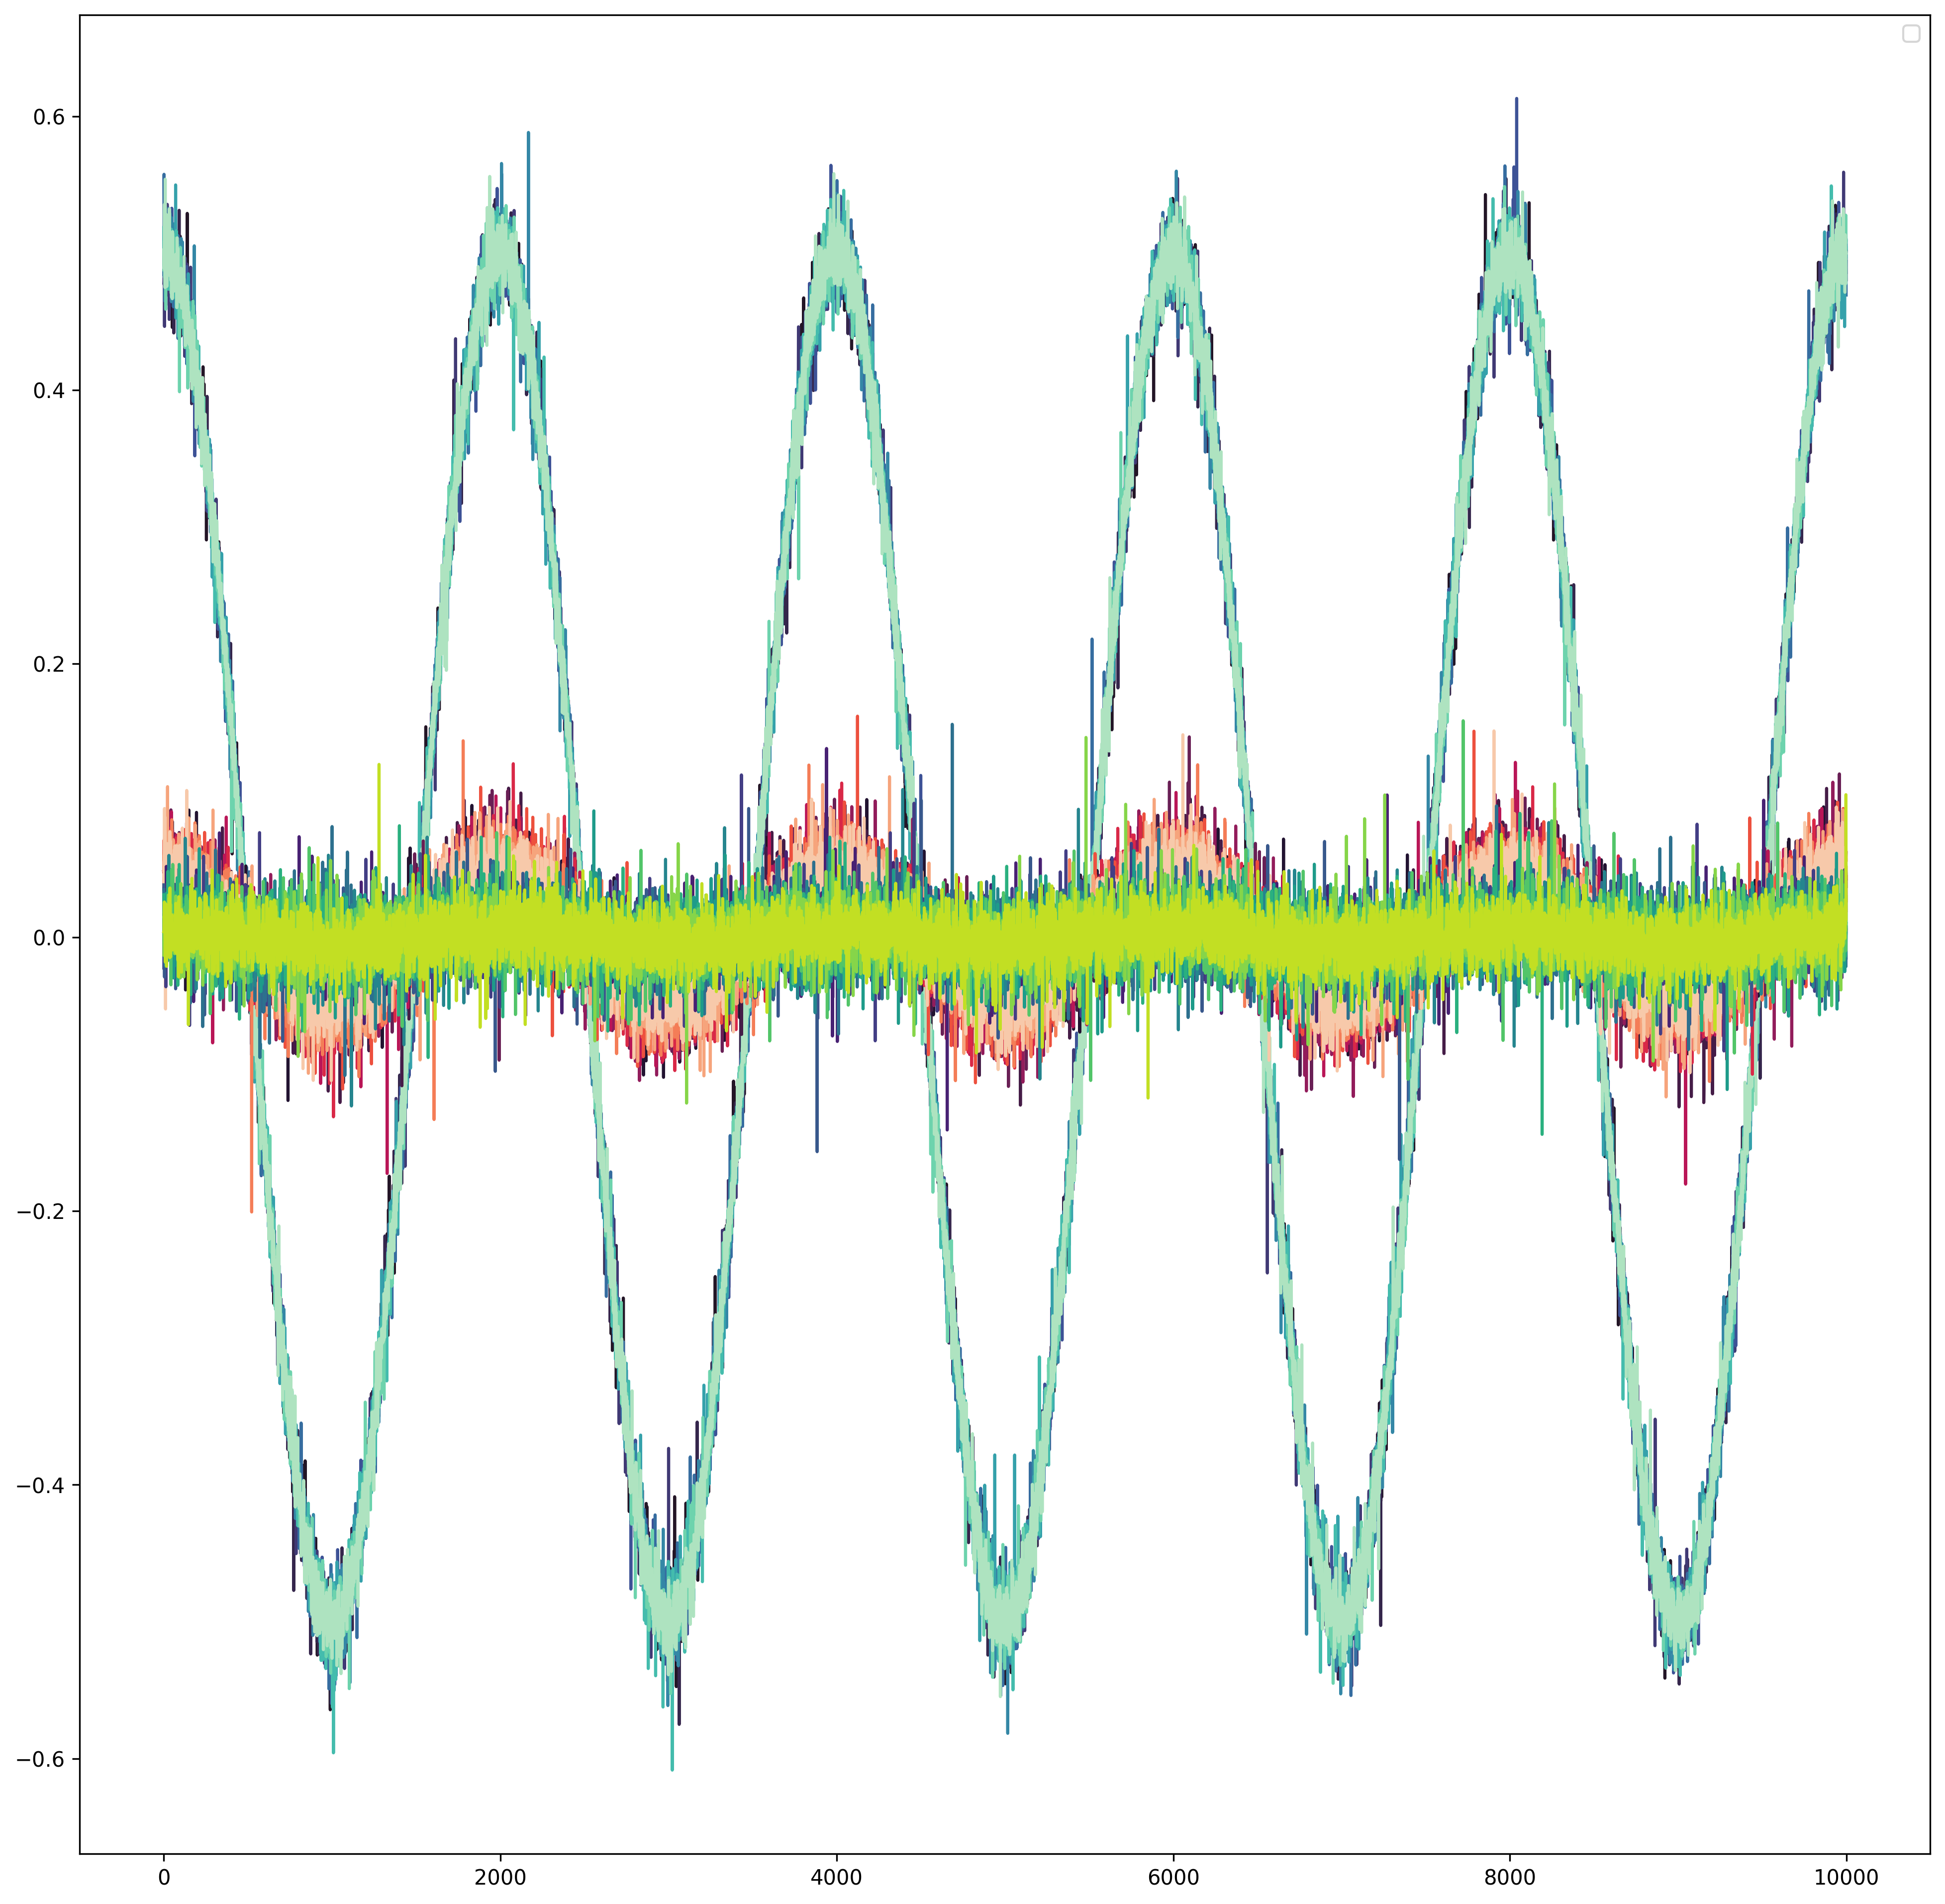

In [6]:
plt.figure(figsize=(16,16), dpi=300)
sns.lineplot(data=large_wave_gen.sample(10).T, palette='mako', dashes=False)
sns.lineplot(data=small_wave_gen.sample(10).T, palette='rocket', dashes=False)
sns.lineplot(data=flat_wave_gen.sample(10).T, palette='viridis', dashes=False)
plt.legend([])
plt.show()

In [ ]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.size == train_size
    assert test_indices.size == n_samples - train_size
    
    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices,:]
        test_data = tensor[test_indices,:]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_dict(dataset_dict, separate=True):
    tensors = list()
    for label, arr in dataset_dict.items():
        # convert this from arr to tensor after numpy change
        dataset_samples = arr.shape[0]
        input_tensor = torch.from_numpy(arr)
        label_tensor = torch.full((dataset_samples, ), label).unsqueeze(dim=-1)
        if separate:
            tensors.append((input_tensor, label_tensor))
        else:
            tensor = torch.cat([input_tensor, label_tensor], dim=1)
            tensors.append(tensor)
            
    if separate:
        input_tensors, label_tensors = zip(*tensors)
        input_tensor = torch.cat(input_tensors, dim=0).unsqueeze(axis=1).double()
        label_tensor = torch.cat(label_tensors, dim=0).double()
        return input_tensor, label_tensor
    else:
        tensor = torch.cat(tensors, dim=0).double()
        return tensor
    
class TorchDataset(Dataset):
    def __init__(self, input_tensor, label_tensor):
        assert input_tensor.shape[0] == label_tensor.shape[0]
        self.data = input_tensor
        self.label = label_tensor
        return

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]
        return data, label

In [7]:
dataset_samples = 100_000
batch_size = 128

dataset_dict = {
    1. : large_wave_gen.sample(dataset_samples),
    .5 : small_wave_gen.sample(dataset_samples),
    0. : flat_wave_gen.sample(dataset_samples),
}
data, labels = torch_data_from_dict(dataset_dict)
train_data, train_labels, test_data, test_labels = torch_train_test_split(data, labels, split=.9)

train_dataset = TorchDataset(train_data, train_labels)
test_dataset = TorchDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(10000, 10001)

(10000, 10001)

(10000, 10001)

(30000, 10001)

In [8]:
class SineCNN(nn.Module):
    def __init__(self, input_size, pool_kernel=4):
        super(SineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=100, stride=10)
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.maxpool = nn.MaxPool1d(kernel_size=pool_kernel)
        self.fc1 = nn.Linear((input_size - pool_kernel) // pool_kernel * 16, 32)
        self.dout1 = nn.Dropout(p=.4)
        self.fc2 = nn.Linear(32, 1)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dout1(x)
        x = self.fc2(x)
        x = self.output(x).squeeze()
        return x

model = SineCNN(Xy.shape[1] - 1).double()

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.16708009590080358


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([48, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.48828125
0.501953125
0.408203125
0.4375
0.427734375
0.458984375
0.400390625
0.40234375
0.41015625
0.439453125
0.3984375
0.44921875
0.421875
0.474609375
0.388671875
0.37109375
0.439453125
0.451171875
0.412109375
0.361328125
0.40625
0.431640625
0.435546875
0.40234375
0.361328125
0.376953125
0.416015625
0.4609375
0.33203125
0.375
0.443359375
0.41015625
0.443359375
0.4921875
0.41796875
0.4375
0.384765625
0.521484375
0.365234375
0.46875
0.44140625
0.478515625
0.423828125
0.404296875
0.39453125
0.359375
0.470703125
0.396484375
0.45703125
0.40234375
0.4609375
0.400390625
0.376953125
0.380859375
0.427734375
0.443359375
0.41015625
0.431640625
0.40234375
0.462890625
0.416015625
0.43359375
0.3828125
0.36328125
0.380859375
0.466796875
0.3671875
0.388671875
0.525390625
0.416015625
0.40234375
0.453125
0.416015625
0.435546875
0.376953125
0.44921875
0.404296875
0.423828125
0.427734375
0.431640625
0.404296875
0.4453125
0.375
0.388671875
0.3984375
0.408203125
0.380859375
0.3828125
0.400390625
0.355468

C:\Users\Nick\AppData\Local\Temp\ipykernel_39536\74713000.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(items, dashes=False, palette='Spectral')


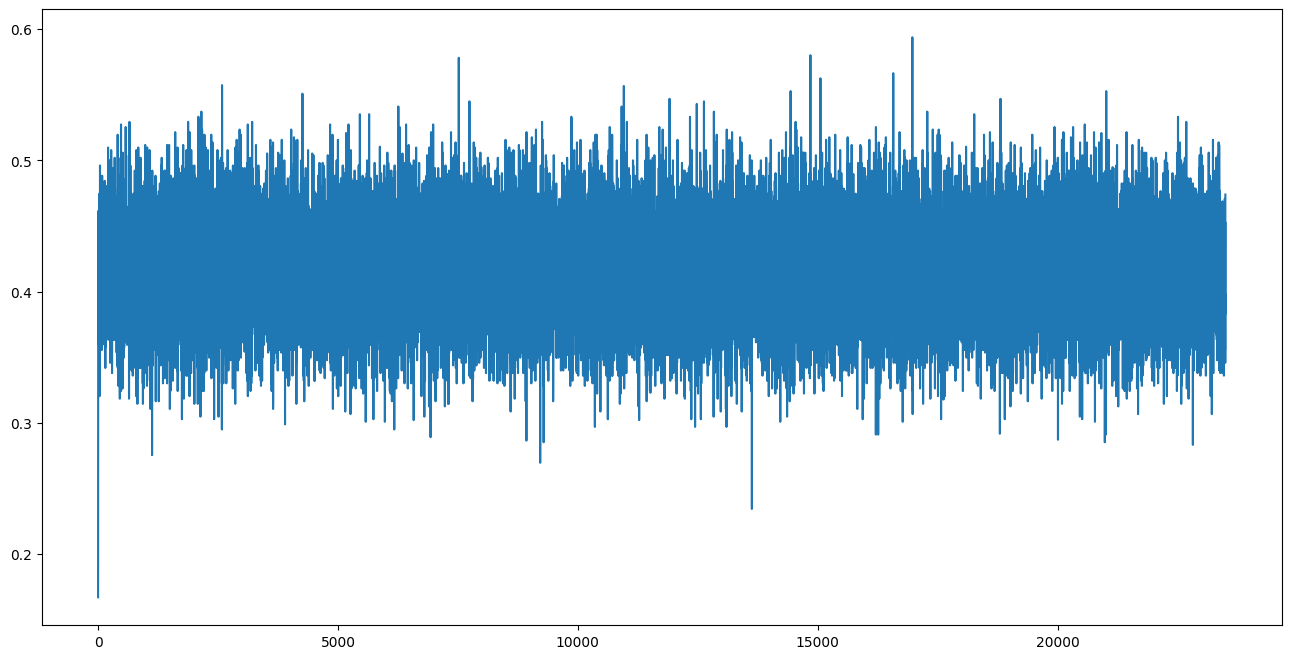

AssertionError: 

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())
n_epochs = 1000
items = list()

for epoch in range(n_epochs):
    p = True
    for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
        optimizer.zero_grad()
        train_outputs = model(train_data)
        
        train_loss = criterion(train_outputs, train_labels)       
        train_loss.backward()
        optimizer.step()
        
        test_outputs = model(test_data)
        test_loss = criterion(test_outputs, test_labels)
        
        if p and not epoch % 100:
            print('Train Loss', train_loss.item())
            print('Test Loss', test_loss.item())
            p = False
        items.append((train_loss.item(), test_loss.item()))
        
plt.figure(figsize=(16,8))
train_loss, test_loss = zip(*items)
sns.lineplot(train_loss, dashes=False, palette='Spectral', label='Train MSE')
sns.lineplot(test_loss, dashes=False, palette='Spectral', label='Test MSE')
plt.show()
assert False

In [ ]:
def base_wave(n_periods=1, phase_angle=0, arr_len=100):
    return np.sin(np.linspace(phase_angle,n_periods*np.pi*2+phase_angle,arr_len))

def bias_amplitude(arr, amplitude=.5, bias=.5):
    if amplitude != 1:
        arr = np.multiply(arr, amplitude)
    if bias:
        arr = np.add(arr, bias)
    return arr

def pixel_period(arr, pixel_period=.5):
    if 0 < period < 1:
        period = int(period * len(arr))
    arr = np.resize(arr, (period))
    return arr

def pad_wave(arr, pad_size, pad_split, ret_indices=True):
    assert round(sum(pad_split),3) == 1, f'pad_split {pad_split} must add to 1, not {sum(pad_split)}'
    assert len(pad_split) == 2
    left_pad_size = int(pad_size * pad_split[0])
    right_pad_size = pad_size - left_pad_size
    
    left_pad = np.zeros(left_pad_size)
    right_pad = np.zeros(right_pad_size)
    
    arr = np.concatenate((left_pad, arr, right_pad), axis=0)
    if ret_indices:
        indices = ~arr.astype(np.bool_)
        return arr, indices
    return arr

def pixel_wave(pixel_period, amplitude, bias, arr_len, pad_split=(.5,.5), **base_kwargs):
#     arr_len = base_kwargs['arr_len']
    if 0 < pixel_period < 1:
        pixel_period = int(pixel_period * len(arr_len))
#     base_kwargs['arr_len'] = pixel_period
    wave = base_wave(arr_len=pixel_period, **base_kwargs)
    wave = bias_amplitude(wave, amplitude=amplitude, bias=bias)
    
    pad_size = (arr_len - pixel_period)
    wave = pad_wave(wave, pad_size, pad_split)
    return wave

def verify_indices(indices, arr=None, pad_val=0):
    assert indices.ndim == 1
    assert indices.dtype == np.bool_
    if arr:
        assert arr.shape == indices.shape
        assert indices[arr == pad_val].all() == True
    return
    
def noise_patch(arr, indices, start, stop, **noise_kwargs):
    indices[start:stop] = True
    arr[start:stop] = add_noise(arr[start:stop], **noise_kwargs)
    return arr, indices
    
def add_edge_noise(arr, indices, start=0, stop=-1, size_range=(.05,.1), pad_val=0, ret_indices=True, **noise_kwargs):
    valid_size = len(indices)
    false_indices = np.where(indices==False)
    patch_min = np.amin(false_indices)
    patch_max = np.amax(false_indices)
    
    left_size = int(valid_size * np.random.uniform(*size_range))
    right_size = int(valid_size * np.random.uniform(*size_range))
    
    arr, indices = noise_patch(arr, indices, patch_min, patch_min + left_size, **noise_kwargs)
    arr, indices = noise_patch(arr, indices, patch_max - right_size, patch_max, **noise_kwargs)
    return arr, indices

def plot_wave(wave, indices=None, i=''):
    if isinstance(i, int): i = ' ' + str(i)
    plt.figure(figsize=(16,4), dpi=200)
    x=[i for i in range(len(wave))]
    assert wave.ndim == 1
    sns.lineplot(x=x, y=wave, label=f'Wave{i}')
    if indices is not None:
        verify_indices(indices)
        sns.lineplot(x=x, y=indices, label=f'Label{i}')
    plt.legend()
    plt.show()
    return

arr, indices = pixel_wave(120, .4, .5, 200)
plot_wave(arr)
slanted_arr = np.add(arr, np.linspace(0, len(arr)*.005, len(arr)))
plot_wave(slanted_arr)
arr, indices = add_edge_noise(arr, indices)
plot_wave(arr)
plot_wave(indices)

In [ ]:
wave = base_wave()
plot_wave(wave)

In [ ]:
ARG_STEPS = 20
amplitudes = np.arange(.1,1,ARG_STEPS)
pixel_periods = np.arange(60,SINE_LEN,ARG_STEPS)
phase_angles = np.arange(0,np.pi,ARG_STEPS)

y_list = list()
X_list = list()
for i, args in enumerate(itertools.product(amplitudes, pixel_periods, phase_angles)):
    y_list.append(np.repeat(args, NOISE_SAMPLES))
    amplitude, pixel_period, phase_angle = args
    X_list.append(
        np.vstack(
            [
                pixel_wave(
                    pixel_period, 
                    amplitude, 
                    .5, 
                    n_periods=1, 
                    phase_angle=phase_angle, 
                    arr_len=SINE_LEN
                ) 
                for _ 
                in range(NOISE_SAMPLES)
            ]
        )
    )
    if i % 1000 == 0:
        sns.lineplot(data=X_list[-1].transpose())
        plt.show()
        
y_train = np.concatenate(y_list, axis=0)
print(y_train.shape)
X_train = np.concatenate(X_list, axis=0)
print(X_train.shape)       

### Sinc Wave Generation

## Simple Keras Network

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Nadam
from keras.layers import LeakyReLU

# define the input 

In [ ]:
inputs = Input(shape=(SINE_LEN,))

def create_hidden(arr, neurons, alpha=.1):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    return arr

def create_output(arr, neurons, name):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    arr = Dense(1, name=name)(arr)
    return arr

hidden1 = create_hidden(inputs, 128)
hidden2 = create_hidden(hidden1, 64)
hidden3 = create_hidden(hidden2, 32)

# define the output layer
output1 = create_output(hidden3, 32, 'output1')
output2 = create_output(hidden3, 32, 'output2')

loss_weights = {'output1': 0.5, 'output2': 0.5}

model = Model(inputs=inputs, outputs=[output1, output2])
model.compile(loss='mean_squared_error', optimizer=Nadam(lr=0.002), loss_weights=loss_weights)
model.summary()

### Add Callbacks

## Duplicate PyTorch Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(SINE_LEN, 128),
            LeakyReLU(),
            nn.Linear(128, 64),
            LeakyReLU(),
            nn.Linear(64, 32),
            LeakyReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        output1 = self.model(x)
        output1 = self.output(output1)
        output2 = self.model(x)
        output2 = self.output(output2)
    
        return output1, output2

model = Net()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters())
for epoch in range(N_EPOCHS):
    inputs = X
    targets = X
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch} Loss: {loss}')

## Sine Wave Side to Side

## Sine Wave Single Period